So we need to calculate the phase where the maximum SIF occurs.  
Let's test out the methods we have to do this to make sure eveything is working.

In [32]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
# %matplotlib notebook
from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import multiprocessing
from functools import partial
import crevasse as c # main module for this project
from importlib import reload
reload(c)
print (dolfin.__version__)

2019.1.0


In [29]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

D = mats['E']/(1-mats['nu']**2) * geom['H']**3 / 12
flexural_gravity_wavelength = 2*pi*(D/(mats['rhow']*mats['g']))**(1/4)

# Lcs_swell = Lcs
Lcs_swell = np.linspace(10,3*flexural_gravity_wavelength,10000)
# Lcs_swell = (100,200,300,600,1200,2400,4800,9600,19200)

In [38]:
# First get the result visually, witout calling the dedicated code

crevasse_locations = (4505,4510)
phases = np.arange(0,2*np.pi,1)
KI=[[],[]]
KII=[[],[]]

for i,this_Lc in enumerate(crevasse_locations):
    g=geom
    g['Lc'] = this_Lc
    for this_phase in phases:
        print(this_phase)
        these_Ks = c.sif(g,mats,verbose=True,loc='surface', 
                         swell_amplitude=1.0,swell_phase=this_phase)
        KI[i].append(these_Ks[0])
        KII[i].append(these_Ks[1])    

0.0
1.0
2.0
3.0
4.0
5.0
6.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0


In [ ]:
# Now call the dedicated code
test_4505 = c.find_max_phase('surface','I',4505,geom,mats,verbose=True)
test_4510 = c.find_max_phase('surface','I',4510,geom,mats,verbose=True)

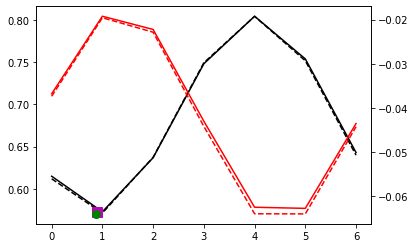

In [61]:
fig,ax1=plt.subplots()
ax1.plot(phases,np.array(KI[0])/1e6,'-k')
ax2 = ax1.twinx()
ax2.plot(phases,np.array(KII[0])/1e6,'-r')

ax1.plot(phases,np.array(KI[1])/1e6,'--k')
ax2.plot(phases,np.array(KII[1])/1e6,'--r')

ax1.plot(test_4505[0],test_4505[1]/1e6,'sm',markersize=10)
ax1.plot(test_4510[0],test_4510[1]/1e6,'og',markersize=8)

In [ ]:
# Conclusion: the function c.find_max_phase works as intended.

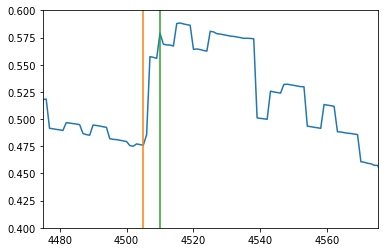

In [45]:
with open('swell-sifs-high-res-linear.pkl', 'rb') as f:
    output = pickle.load(f)
plt.subplots()
plt.plot(np.array(output[0])[:,1]/1e6)
plt.xlim([4475,4575])
plt.ylim(np.array([400e3,600e3])/1e6)
plt.plot([4505,4505],[.4,.6])
plt.plot([4510,4510],[.4,.6])

In [37]:
g=geom
g['Lc'] = 4505
c.sif(g,mats,verbose=False,loc='surface', swell_amplitude=1.0,swell_phase=2.399963)

(681524.90527350281, -29248.135817633272)

In [47]:

print(test_4505)
print(test_4510)

Finding Phase with max K:
     Phase = 2.399963 rad
     KI = 681524.931964
     Phase = 3.883222 rad
     KI = 803435.420743
     Phase = 1.483259 rad
     KI = 592000.980079
     Phase = 0.916704 rad
     KI = 572009.029450
     Phase = 0.780403 rad
     KI = 572627.082579
     Phase = 0.888571 rad
     KI = 571959.689007
     Phase = 0.887554 rad
     KI = 571959.630065
     Phase = 0.887887 rad
     KI = 571959.636124
     Phase = 0.887220 rad
     KI = 571959.636932
Finding Phase with max K:
     Phase = 2.399963 rad
     KI = 682527.319270
     Phase = 3.883222 rad
     KI = 803566.250819
     Phase = 1.483259 rad
     KI = 591490.372251
     Phase = 0.916704 rad
     KI = 570281.312155
     Phase = 0.751278 rad
     KI = 570984.028376
     Phase = 0.871289 rad
     KI = 570155.153241
     Phase = 0.870271 rad
     KI = 570155.094597
     Phase = 0.870605 rad
     KI = 570155.100446
     Phase = 0.869938 rad
     KI = 570155.101767
(0.88755352758720052, 571959.63006498839)
(0.870